In [22]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f"{images_path} directory exists.")
else:
    print(f"Did not find {images_path} directory, creating one...")
    images_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(images_path)

data/pizza_steak_sushi directory exists.


In [23]:
train_dir = images_path / "train"
test_dir = images_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [25]:
import random
from PIL import Image # python image library

images_path_list = list(images_path.glob("*/*/*.jpg"))
random_image_path = random.choice(images_path_list) # get a random image file from all the imgs
image_class = random_image_path.parent.stem # parent dir name
img = Image.open(random_image_path)

print(f"Random image pat: {random_image_path}")
print(f"Image class: {image_class}")
print(f"CHW: {img.mode}, {img.height}, {img.width}")
#img

Random image pat: data/pizza_steak_sushi/train/pizza/68684.jpg
Image class: pizza
CHW: RGB, 384, 512


In [34]:
import torch
import pathlib
import os

import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cuda


In [180]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [181]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [182]:
class_names = train_data_augmented.classes

In [183]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)
train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x78ef9904fac0>,
 <torch.utils.data.dataloader.DataLoader at 0x78ef9b5e6110>)

In [201]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [202]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # normalize y_pred on probability distribution then get argmax
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [203]:
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [204]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
         loss_fn: torch.nn.Module, epochs: int=5, e_print: int=1):
    results = {"train_loss": [], "train_acc": [],
               "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        if epoch % e_print == 0:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [213]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3,hidden_units=60,
                 output_shape=len(train_data_augmented.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001, momentum=0.9)
#optimizer = torch.optim.RMSprop(params=model_0.parameters(), lr=0.01, momentum=0.9)

In [214]:
# training
from timeit import default_timer as timer
start_time = timer()
NUM_EPOCHS = 100

model_0_results = train(model=model_0, train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, e_print=10)
end_time = timer()
print(f"Total running time: {end_time-start_time:.3f} seconds")

Epoch: 1 | train_loss: 1.1255 | train_acc: 0.3086 | test_loss: 1.0751 | test_acc: 0.3011
Epoch: 11 | train_loss: 0.8523 | train_acc: 0.5898 | test_loss: 1.0811 | test_acc: 0.3229
Epoch: 21 | train_loss: 0.9675 | train_acc: 0.4844 | test_loss: 1.0885 | test_acc: 0.4943
Epoch: 31 | train_loss: 0.8867 | train_acc: 0.6523 | test_loss: 1.0662 | test_acc: 0.4867
Epoch: 41 | train_loss: 0.7953 | train_acc: 0.6992 | test_loss: 1.0378 | test_acc: 0.4754
Epoch: 51 | train_loss: 0.5894 | train_acc: 0.6719 | test_loss: 1.1837 | test_acc: 0.4555
Epoch: 61 | train_loss: 0.6094 | train_acc: 0.7578 | test_loss: 1.1513 | test_acc: 0.5057
Epoch: 71 | train_loss: 0.5382 | train_acc: 0.8086 | test_loss: 1.0294 | test_acc: 0.5152
Epoch: 81 | train_loss: 0.4675 | train_acc: 0.8398 | test_loss: 1.1467 | test_acc: 0.5360
Epoch: 91 | train_loss: 0.4225 | train_acc: 0.8477 | test_loss: 1.1566 | test_acc: 0.4451
Total running time: 120.133 seconds


In [ ]:
# how to deal with overfitting
# - get more data
# - simplify the model (less layers/units)
# - use data augmentation
# - use transfer learning
# - use dropout layers (randomly remove connections between hidden layers making model more simple)
# - use learning reate decay (the closer you get, the smaller your steps)
# - stop early (stop trianing before the overfitting starts or accelerates)

# how to deal with underfitting
# - add more layers/units to the model
# - tweak the learning rate
# - use transfer learning
# - train for more epochs (longer)
# - use less regularization

In [45]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [130]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

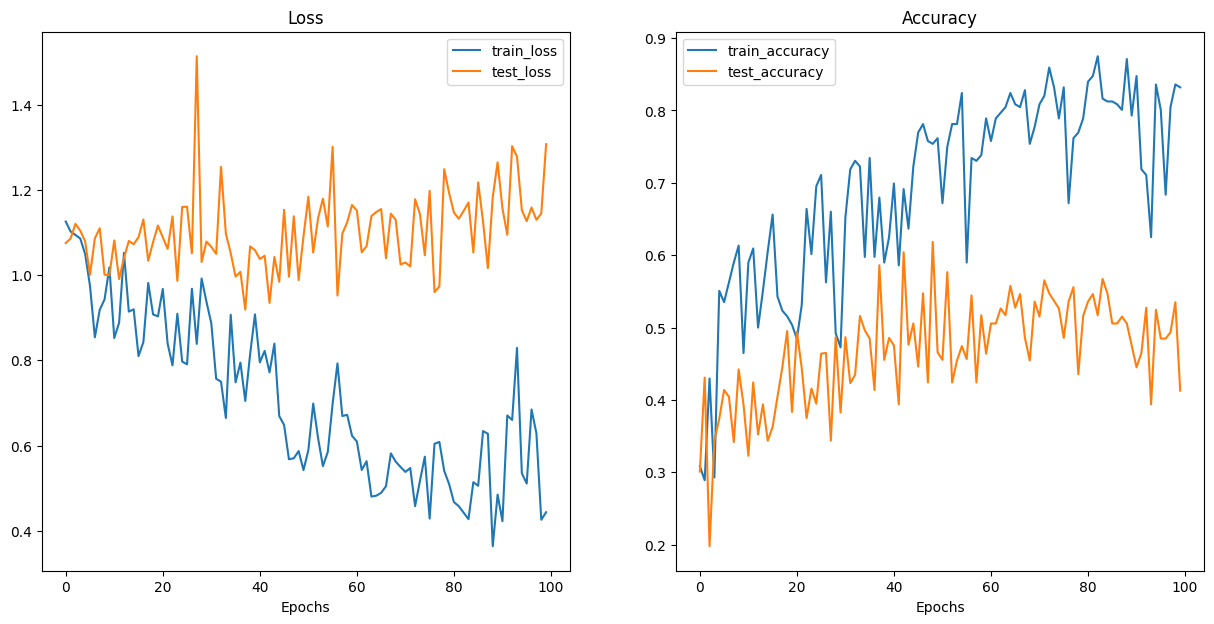

In [215]:
plot_loss_curves(model_0_results)